### Paper Choice and Background Outline

- In my project, I will implement the algorithm developed by Dennis D. Boos, Leonard A. Stefanski and Yujun Wu in their article "Fast FSR Variable Selection with Applications to Clinical Trials".

- Many variable selection procedures have been developed in the literature for linear regression models. This paper proposed an updated version of False Selection Rate (FSR) method to control variable selection without simulation. By adding a number of phony variables to the real set of data and monitoring the proportion of the phony variables falsely selected as a function of the tuning parameter, like α-to-enter of forward selection, FSR is able to estimate the appropriate tuning parameter and control the model false selection rate, selecting informative variables and preventing uninformative ones from being selected. Fast FSR in this paper allows us to estimate the tuning parameter from the summary table of the forward selection variable sequence. As a consequence, Fast FSR improve FSR algorithm by skipping the step of generating phony variables.

### Pseudocode

- Step 1: Use forward selection to generate the sequence of variables and the associated p-values.

- Step 2: Monotonize the p-value of the original sequence by carrying the larger p-value forward until a even larger p-value. Denote the monotonized p-value sequence with
$$
\tilde{p_1}\leq\tilde{p_2}\leq\cdots\leq\tilde{p_k}\\
$$

- Step 3: For each variable $x_i$ in the selection sequence, calculate the associated

$$
\hat{\alpha_i} = \frac{\gamma(1+S_i)}{k-S_i}  \\
$$

, where $\gamma$ is the pre-determined average selection rate of uninformative variables in the model. $S_i$ is the model size associated with the variables in the sequence. 

- Step 4: Compare $\tilde{p_i}$ and $\hat{\alpha_i}$. Select the model of size $j$, where $j = max\{i: \tilde{p_i}\leq\hat{\alpha_i}\}$. Also, return the corresponding $\hat{\alpha_i}$.

### Unit Tests 

- Test the algorithm with data Mangold, Bean, Adams (2003), Journal Of Higher Education, p. 540-562, "The Impact of Intercollegiate Athletics on Graduation Rates Among Major NCAA Division I Universities.", which is saved in http://www4.stat.ncsu.edu/~boos/var.select/ncaa.data2.txt, and compare my output with the result by Dennis D. Boos and Leonard A. Stefanski.

### Install "leaps" Package

In [2]:
%load_ext rpy2.ipython

In [3]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
p1=importr('leaps')
p2=importr('stats')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### FSR Algorithm Code

In [9]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import multiprocessing
from functools import partial
from sklearn.linear_model import Lasso
from sklearn import datasets, linear_model
%matplotlib inline
%precision 4
plt.style.use('ggplot')

ImportError: No module named patsy

In [5]:
def fsr_fast(x,y,gam0=.05,digits=4):
    
    m = x.shape[1]
    n = x.shape[0]  
    
    pvm = np.zeros(m)                      
    
    # obtain the forward selection sequence
    out_x = p1.regsubsets(x,y,method="forward") 
    
    rss = out_x[9]
    nn = x.shape[0]
    vorder = np.array(out_x[7])[1:]-1
 
    q = [(rss[i]-rss[i+1])*(nn-i-2)/rss[i+1] for i in range(len(rss)-1)]
   
    # calculate the p-value of each variable entered
    orig = [1-stats.f.cdf(q[i],1,nn-i-2) for i in range(len(rss)-1)] 
    
    # monotonize the p-value of the original sequence 
    for i in range(0,m):
        pvm[i] = max(orig[0:i+1])  
   
    # calculate the associate alpha
    S = np.arange(1,m+1)
    alpha = gam0*(1+S)/(m-S) 
    
    # select the variables and determine the model size
    for i in range(0,m):
        if orig[i]>orig[i+1]:
            i = i+1
        elif pvm[i]<alpha[i] and pvm[i]<gam0:
            i = i+1
        else:
            break
        i = i-1
        
    svorder = np.array(vorder[0:i])-1
    data_x = x.iloc[:,svorder]
    data_x = sm.add_constant(data_x)
   
    regr = sm.OLS(y,data_x).fit()
    
    return regr, list(data_x.columns.values)

### Test with Real Data

In [1]:
import os   
import pandas as pd
if not os.path.exists('NCAA.txt'):
    ! wget http://www4.stat.ncsu.edu/~boos/var.select/ncaa.data2.txt -O NCAA.txt
data = pd.read_csv('NCAA.txt',delim_whitespace = True).dropna()
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,y
0,13,17,9,15,28.0,0,-1.14045,3.660,4.490,3409,65.8,18,81,42.2,660000,77,100,59,1,35.0
1,28,20,32,18,18.4,18,-0.13719,2.594,3.610,7258,66.3,17,82,40.5,150555,88,94,41,25,57.0
2,32,20,20,20,34.8,18,1.55358,2.060,4.930,6405,75.0,19,71,46.5,415400,94,81,25,36,51.3
3,32,21,24,21,14.5,20,2.05712,2.887,3.876,18294,66.0,16,84,42.2,211000,93,88,26,13,41.3
4,24,20,16,20,21.8,13,-0.77082,2.565,4.960,8259,63.5,16,91,41.2,44000,90,92,32,31,65.7


In [7]:
data_x = data.ix[:,range(0,19)]
data_y = data.ix[:,19]

In [8]:
fsr_fast(data_x,data_y,gam0=.05,digits=4)[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     75.50
Date:                Tue, 22 Mar 2016   Prob (F-statistic):           2.49e-30
Time:                        14:49:48   Log-Likelihood:                -315.88
No. Observations:                  94   AIC:                             643.8
Df Residuals:                      88   BIC:                             659.0
Df Model:                           5                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -42.1069      8.990     -4.684      0.000       -59.972   -24.242
x2             3.4714      0.467      7.428      0.000         2.543     4.400
x3             0.2391      0.076      3.163      0.002         0.089     0.389
x5             0.2787      0.078      3.582      0.001         0.124     0.433
x4             0.6770      0.195      3.475      0.001         0.290     1.064
x7            -2.5913      0.832     -3.115      0.002        -4.245    -0.938
==============================================================================
Omnibus:                        5.624   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.905
Skew:                           0.351   Prob(JB):                        0.142
Kurtosis:                       2.290   Cond. No.                         620.
==============================================================================
"""

It can be shown that my algorithm returns the same result as the one by Dennis D. Boos and Leonard A. Stefanski, which is saved in http://www4.stat.ncsu.edu/~boos/var.select/fsr.fast.ncaa.ex.txt

### Method Comparision : Lasso and Fast FSR

- In this section, we compare the performance of lasso and fast FSR in term of Average Model Error, Average False Selection Rate with the simulated data and running time with real data. 
- Model Error is defind as mean squared error:
$$
n^{-1}\times\sum_{i=1}^{n} (\hat{f}(x_i)-y_i)^2
$$
- False Selection Rate is the proportion of uninformative variables selected in the model:
$$
\frac{U(Y,X)}{1+I(Y,X)+U(Y,X)}
$$
,where $U(Y,X)$ and $I(Y,X)$ are the number of uninformative and informative variables in the model.
- We simulated 150 data points with 42 variables. Four models are simulated: H1: all the coefficient of variables (beta) are zeros. H2: 6 nonzero betas at variables 6–8 and 13–15 with values (9,4,1). H3: 10 nonzero betas at variables 5–9 and 12–16 with values (25,16,9,4,1). H4: 14 nonzero betas at variables 4–10 and 11–17 with value (49, 36, 25, 16, 9, 4, 1)
- Repeat the algorithm for 50 times, save each model error and false selection rate. 
- Plot the Average Model Error and Average False Selection of lasso and fast FSR for the four models


In [9]:
# all beta's are zero
def model1():
    y = np.random.normal(1, 1, 1500)
    x = pd.DataFrame(np.random.normal(1, 1, 21*1500).reshape(1500,21))
    quad1 = x**2
    x = pd.DataFrame(np.concatenate((x,quad1),axis=1))
    true = []
    return x, y, true

In [10]:
# 6 ,7 ,8, 13, 14, 15th beta are (9,4,1,9,4,1)
def model2():
    x = pd.DataFrame(np.random.normal(1, 1, 21*1500).reshape(1500,21))
    y = 9*x.ix[:,5]+4*x.ix[:,6]+x.ix[:,7]+9*x.ix[:,12]+4*x.ix[:,13]+x.ix[:,14]

    quad2 = x**2
    x = pd.DataFrame(np.concatenate((x,quad2),axis=1))
    true = np.array([6,7,8,13,14,15])-1
    return x,y,true

In [11]:
# 5, 6 ,7 ,8, 9, 12, 13, 14, 15, 16th beta are (25,16,9,4,1,25,16,9,4,1)
def model3():
    x = pd.DataFrame(np.random.normal(1, 1, 21*1500).reshape(1500,21))
    y = 25*x.ix[:,4]+16*x.ix[:,5]+9*x.ix[:,6]+4*x.ix[:,7]+1*x.ix[:,8]+25*x.ix[:,11]+16*x.ix[:,12]+9*x.ix[:,13]+4*x.ix[:,14]+1*x.ix[:,15]

    quad2 = x**2
    x = pd.DataFrame(np.concatenate((x,quad2),axis=1))
    true = np.array([5,6,7,8,9,12,13,14,15,16])-1
    return x,y,true

In [12]:
# 4-10th and 11-17th beta are (49,36,25,16,9,4,1,49,36,25,16,9,4,1)
def model4():
    x = pd.DataFrame(np.random.normal(1, 1, 21*1500).reshape(1500,21))
    y = 49*x.ix[:,3]+36*x.ix[:,4]+25*x.ix[:,5]+16*x.ix[:,6]+9*x.ix[:,7]+4*x.ix[:,8]+x.ix[:,9]+49*x.ix[:,10]+36*x.ix[:,11]+25*x.ix[:,12]+16*x.ix[:,13]+9*x.ix[:,14]+4*x.ix[:,15]+x.ix[:,16]

    quad2 = x**2
    x = pd.DataFrame(np.concatenate((x,quad2),axis=1))
    true = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16,17])-1
    return x,y,true

In [13]:
# Function to calculate Model Errors
def ME(model,n):
    LASSO_ME = []
    FSR_ME =[]
    for i in range(n):
        data = model()
        x = data[0]
        y = data[1]
        m = y.shape[0]
        #LASSO
        alpha = 0.05
        lasso = Lasso(alpha=alpha, tol=0.001)
        y_coef_lasso = lasso.fit(x, y).coef_
        LASSO_me = np.sum((np.dot(x,y_coef_lasso)-np.array(y))**2)/m
        LASSO_ME.append(LASSO_me)
    
        #FSR
        FSR_coef = fsr_fast(x,y,gam0=.05,digits=4)[0].params
        FSR_variable = fsr_fast(x,y,gam0=.05,digits=4)[1][1:]
        variable = np.column_stack((np.ones((m, 1)),x.ix[:,FSR_variable]))
        FSR_me = np.sum((np.dot(variable,FSR_coef)-np.array(y))**2)/m
        FSR_ME.append(FSR_me)
    
    return LASSO_ME,FSR_ME

In [14]:
# Function to calculate the False Selection Rate  
def FSR(model,n):
    LASSO_FSR = []
    FSR_FSR =[]
    for i in range(n):
        data = model()
        true = data[2]
        x = data[0]
        y = data[1]
    
        #LASSO
        alpha = 0.05
        lasso = Lasso(alpha=alpha, tol=0.001)
        y_coef_lasso = lasso.fit(x, y).coef_
        lasso_index = np.where(y_coef_lasso != 0)[0]
    
        informative = set(true)&set(lasso_index)
        LASSO_fsr = (len(lasso_index)-len(informative))/(1.0+len(lasso_index))
        LASSO_FSR.append(LASSO_fsr)
    
        #FSR
        FSR_index = fsr_fast(x,y,gam0=.05,digits=4)[1][1:]
        informative = set(true)&set(FSR_index)
        FSR_fsr = (len(FSR_index)-len(informative))/(1.0+len(FSR_index)) 
        FSR_FSR.append(FSR_fsr)
    
    return LASSO_FSR, FSR_FSR

###  Test the algorithm with parallel pragramming

In [15]:
def pi_multiprocessing(method,model,n=50):
    """Split a job of length n into 2 pieces."""
    m = 2
    pool = multiprocessing.Pool(m)
    mapfunc = partial(method,model)
    results = pool.map(mapfunc,[int(n/m)]*m)
    pool.close()
    return results

In [16]:
ME_1 = pi_multiprocessing(ME,model1)
ME_2 = pi_multiprocessing(ME,model2)
ME_3 = pi_multiprocessing(ME,model3)
ME_4 = pi_multiprocessing(ME,model4)
FSR_1 = pi_multiprocessing(FSR,model1)
FSR_2 = pi_multiprocessing(FSR,model2)
FSR_3 = pi_multiprocessing(FSR,model3)
FSR_4 = pi_multiprocessing(FSR,model4)

In [17]:
LASSO_ME_1 = np.mean(ME_1[0][0]+ME_1[1][0])
LASSO_ME_2 = np.mean(ME_2[0][0]+ME_2[1][0])
LASSO_ME_3 = np.mean(ME_3[0][0]+ME_3[1][0])
LASSO_ME_4 = np.mean(ME_4[0][0]+ME_4[1][0])
FSR_ME_1 = np.mean(ME_1[0][1]+ME_1[1][1])
FSR_ME_2 = np.mean(ME_2[0][1]+ME_2[1][1])
FSR_ME_3 = np.mean(ME_3[0][1]+ME_3[1][1])
FSR_ME_4 = np.mean(ME_4[0][1]+ME_4[1][1])

LASSO_FSR_1 = np.mean(FSR_1[0][0]+FSR_1[1][0])
LASSO_FSR_2 = np.mean(FSR_2[0][0]+FSR_2[1][0])
LASSO_FSR_3 = np.mean(FSR_3[0][0]+FSR_3[1][0])
LASSO_FSR_4 = np.mean(FSR_4[0][0]+FSR_4[1][0])
FSR_FSR_1 = np.mean(FSR_1[0][1]+FSR_1[1][1])
FSR_FSR_2 = np.mean(FSR_2[0][1]+FSR_2[1][1])
FSR_FSR_3 = np.mean(FSR_3[0][1]+FSR_3[1][1])
FSR_FSR_4 = np.mean(FSR_4[0][1]+FSR_4[1][1])


In [18]:
FSR_ME

array([  1.0088e+00,   9.7824e-28,   3.0581e-26,   9.5417e-25])

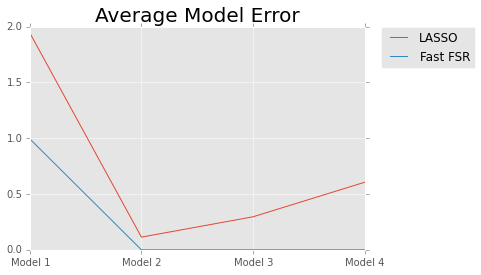

In [20]:
LASSO_ME = np.array([LASSO_ME_1,LASSO_ME_2,LASSO_ME_3,LASSO_ME_4])
FSR_ME = np.array([FSR_ME_1,FSR_ME_2,FSR_ME_3,FSR_ME_4])
model_xticks = ['Model 1','Model 2','Model 3','Model 4']
x = np.array([0,1,2,3])
plt.xticks(x, model_xticks)
plt.plot(LASSO_ME,label='LASSO')
plt.plot(FSR_ME,label="Fast FSR")
plt.title('Average Model Error', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

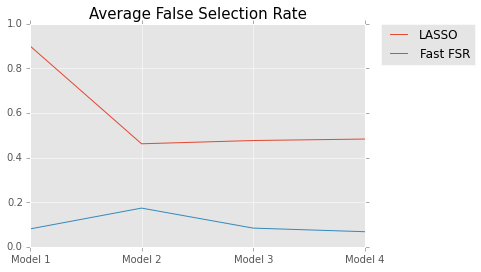

In [21]:
LASSO_FSR = np.array([LASSO_FSR_1,LASSO_FSR_2,LASSO_FSR_3,LASSO_FSR_4])
FSR_FSR = np.array([FSR_FSR_1,FSR_FSR_2,FSR_FSR_3,FSR_FSR_4])
model_xticks = ['Model 1','Model 2','Model 3','Model 4']
x = np.array([0,1,2,3])
plt.xticks(x, model_xticks)
plt.plot(LASSO_FSR,label='LASSO')
plt.plot(FSR_FSR,label='Fast FSR')
plt.title('Average False Selection Rate', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [33]:
%timeit -r1 -n1 fsr_fast(data_x,data_y,.05)
%timeit -r1 -n1 lasso = Lasso(0.05, tol=0.001).fit(data_x, data_y).coef_

1 loops, best of 1: 13.5 ms per loop
1 loops, best of 1: 749 µs per loop


From the above plots we can find that fast FSR is superior to LASSO in terms of false selection rate and model error. However, the built-in Lasso function costs less time. 

### Profiling the Functions and Optimizing the code

In [4]:
! pip install --pre line-profiler &> /dev/null
! pip install psutil &> /dev/null
! pip install memory_profiler &> /dev/null
! pip install line_profiler

Cleaning up...


In [46]:
kernprof -l script_to_profile.py

SyntaxError: invalid syntax (<ipython-input-46-7191dd44a875>, line 1)

In [36]:
@profile
def fsr_fast(x,y,gam0=.05,digits=4):
    
    m = x.shape[1]
    n = x.shape[0]  
    
    pvm = np.zeros(m)                      
    
    # obtain the forward selection sequence
    out_x = p1.regsubsets(x,y,method="forward") 
    
    rss = out_x[9]
    nn = x.shape[0]
    vorder = np.array(out_x[7])[1:]-1
 
    q = [(rss[i]-rss[i+1])*(nn-i-2)/rss[i+1] for i in range(len(rss)-1)]
   
    # calculate the p-value of each variable entered
    orig = [1-stats.f.cdf(q[i],1,nn-i-2) for i in range(len(rss)-1)] 
    
    # monotonize the p-value of the original sequence 
    for i in range(0,m):
        pvm[i] = max(orig[0:i+1])  
   
    # calculate the associate alpha
    S = np.arange(1,m+1)
    alpha = gam0*(1+S)/(m-S) 
    
    # select the variables and determine the model size
    for i in range(0,m):
        if orig[i]>orig[i+1]:
            i = i+1
        elif pvm[i]<alpha[i] and pvm[i]<gam0:
            i = i+1
        else:
            break
        i = i-1
        
    svorder = np.array(vorder[0:i])-1
    data_x = x.iloc[:,svorder]
    data_x = sm.add_constant(data_x)
   
    regr = sm.OLS(y,data_x).fit()
    
    return regr, list(data_x.columns.values)
fsr_fast(data_x,data_y,.05,4)


SyntaxError: invalid syntax (<ipython-input-36-0017d9443e56>, line 47)

In [ ]:
python -m line_profiler script_to_profile.py.lprof

In [34]:
stat = %prun -r -q fsr_fast(data_x,data_y,.05,4)
stat.sort_stats('time').print_stats(15)

          4700 function calls (4616 primitive calls) in 0.023 seconds

   Ordered by: internal time
   List reduced from 358 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       21    0.003    0.000    0.003    0.000 {method 'rcall' of 'rpy2.rinterface.SexpClosure' objects}
       40    0.002    0.000    0.002    0.000 numpy2ri.py:42(numpy2ri)
        1    0.002    0.002    0.011    0.011 functions.py:95(__call__)
        1    0.001    0.001    0.001    0.001 _abcoll.py:545(update)
       19    0.001    0.000    0.005    0.000 _distn_infrastructure.py:1610(cdf)
  398/395    0.001    0.000    0.001    0.000 {numpy.core.multiarray.array}
        1    0.001    0.001    0.023    0.023 <ipython-input-6-630cca1fee41>:1(fsr_fast)
       19    0.001    0.000    0.002    0.000 _distn_infrastructure.py:547(argsreduce)
       58    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
       48    0.000    0.000    0.0

<pstats.Stats instance at 0x7ff66417e128>

In [ ]:
stat.sort_stats('time').print_stats(r'ipython')

In [27]:
%load_ext memory_profiler

In [28]:
%memit fsr_fast(data_x,data_y,.05,4)

peak memory: 127.20 MiB, increment: 0.76 MiB
